In [1]:
import pandas as pd
import numpy as np
from faker import Faker
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
import itertools

In [2]:
# Initialize Faker and set seed for reproducibility
fake = Faker()
np.random.seed(42)

In [3]:
# Parameters
n_users = 2200000  # 2.2 million users
max_registration_steps = 23


In [4]:
# Age categories and probabilities
age_categories = {
    0: (18, 25, 0.52),  # Age 18-25
    1: (26, 35, 0.63),  # Age 26-35
    2: (36, 45, 0.66),  # Age 36-45
    3: (46, 55, 0.69),  # Age 46-55
    4: (56, 65, 0.71),  # Age 56-65
    5: (65, 100, 0.74)  # Age 65+
}

# Looking for gender categories and probabilities
gender_categories = {
    0: ('Male', 'Other', 0.65),
    1: ('Male', 'Male', 0.71),
    2: ('Female', 'Female', 0.72),
    3: ('Male', 'Female', 0.75),
    4: ('Female', 'Other', 0.68),
    5: ('Female', 'Male', 0.79)
}

In [5]:
# Function to assign age category based on probabilities
def assign_age_category():
    category = random.choices(list(age_categories.keys()), 
                              weights=[age_categories[k][2] for k in age_categories])[0]
    age_min, age_max, _ = age_categories[category]
    age = np.random.randint(age_min, age_max)
    return age, category

# Function to assign looking_for_gender category based on probabilities
def assign_looking_for_gender(gender):
    if gender == 'Male':
        gender_cat = random.choices([0, 1, 3], weights=[0.65, 0.71, 0.75])[0]
    elif gender == 'Female':
        gender_cat = random.choices([2, 4, 5], weights=[0.72, 0.68, 0.79])[0]
    else:
        gender_cat = 0  # Defaulting to Male to Other if unspecified
    return gender_cat, gender_categories[gender_cat][2]


In [6]:
# Generate the dataset
data = {
    'user_id': range(1, n_users + 1),
    'gender': np.random.choice(['Male', 'Female', 'Other'], n_users),
    'location': [fake.city() for _ in range(n_users)],
    'interest_categories': np.random.choice(['Tech', 'Sports', 'Music', 'Movies', 'Art'], n_users),
    'completed': np.random.choice([0, 1], n_users, p=[0.34, 0.66]),
    'multi_session': np.zeros(n_users),
    'has_profile_photo': np.zeros(n_users),
    'has_profile_summary': np.zeros(n_users),
    'type_of_device': np.random.choice(['Windows', 'Mac iOS', 'Android Phone', 'iPhone iOS'], n_users),
    'website_or_app': np.random.choice(['Website', 'App'], n_users)
}


In [7]:
# Assign age and age category
age_data = [assign_age_category() for _ in range(n_users)]
data['age'], data['age_category'] = zip(*age_data)


In [8]:
# Assign looking_for_gender category and probability
gender_data = [assign_looking_for_gender(gender) for gender in data['gender']]
data['looking_for_gender_category'], data['looking_for_gender_prob'] = zip(*gender_data)

In [9]:
# Add additional binary columns for optional registration steps
optional_fields = ['relationship_status', 'parenting_status', 'appearance', 'lifestyle', 'education', 
                   'faith', 'ethnicity', 'hometown', 'languages_spoken', 'career', 'political_views', 
                   'pets', 'exercise_habits', 'interests']
for field in optional_fields:
    data[field] = np.random.choice([0, 1], n_users)

In [10]:
# Convert to DataFrame
df = pd.DataFrame(data)


In [11]:
# Manipulate profile photo and multi-session probabilities
df['has_profile_photo'] = np.random.choice([0, 1], size=n_users, p=[0.37, 0.63])
df['multi_session'] = df.apply(lambda row: 1 if row['has_profile_photo'] == 1 and np.random.rand() <= 0.76 else row['multi_session'], axis=1)


In [12]:
# Manipulate profile summary and multi-session probabilities
df['has_profile_summary'] = np.random.choice([0, 1], size=n_users, p=[0.28, 0.72])
df['multi_session'] = df.apply(lambda row: 1 if row['has_profile_summary'] == 1 and np.random.rand() <= 0.70 else row['multi_session'], axis=1)


In [13]:
# Age-related adjustments to multi-session behavior
df['multi_session'] = df.apply(lambda row: 1 if np.random.rand() <= age_categories[row['age_category']][2] else row['multi_session'], axis=1)


In [14]:
# Gender-related adjustments to multi-session behavior
df['multi_session'] = df.apply(lambda row: 1 if np.random.rand() <= row['looking_for_gender_prob'] else row['multi_session'], axis=1)


In [15]:
# Manipulate device type interactions with multi-session behavior
df['multi_session'] = df.apply(lambda row: 1 if row['type_of_device'] == 'iPhone iOS' and row['website_or_app'] == 'App' else row['multi_session'], axis=1)
df['multi_session'] = df.apply(lambda row: 0 if row['type_of_device'] == 'Windows' and row['website_or_app'] == 'Website' else row['multi_session'], axis=1)


In [16]:
# Save to CSV for further analysis
df.to_csv('mock_match_group_users_final_adjusted.csv', index=False)

In [18]:
#Load the generated data
df = pd.read_csv('mock_match_group_users_final_adjusted.csv')

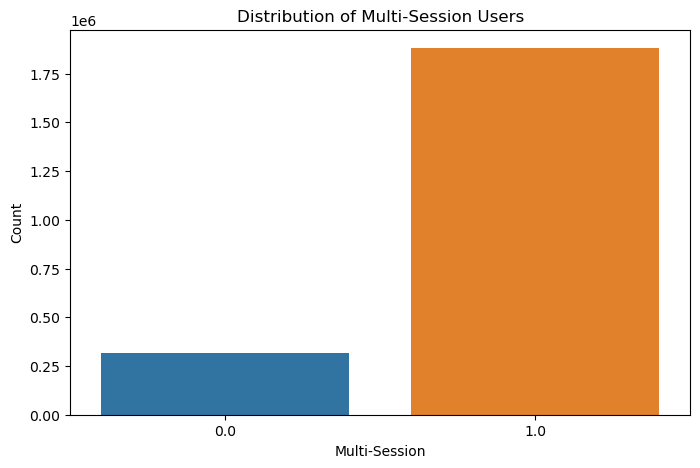

In [19]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='multi_session')
plt.title('Distribution of Multi-Session Users')
plt.xlabel('Multi-Session')
plt.ylabel('Count')
plt.show()

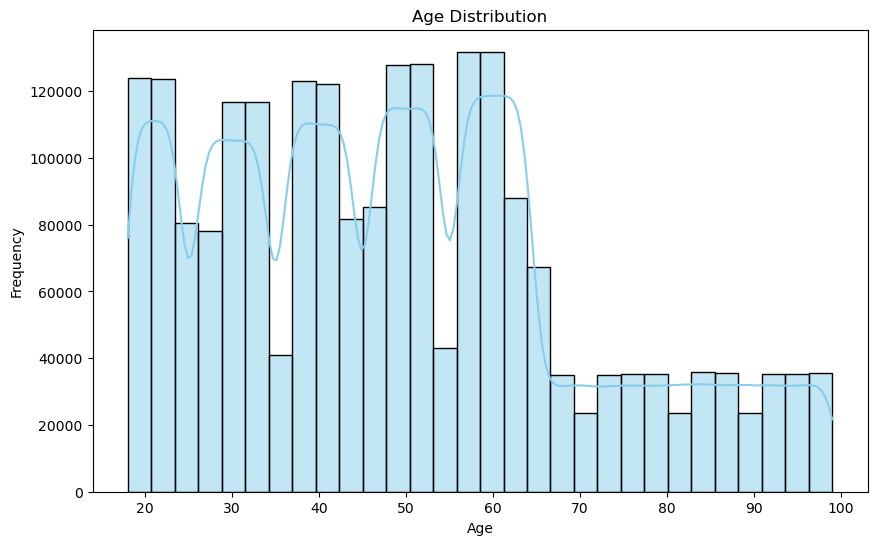

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=30, kde=True, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

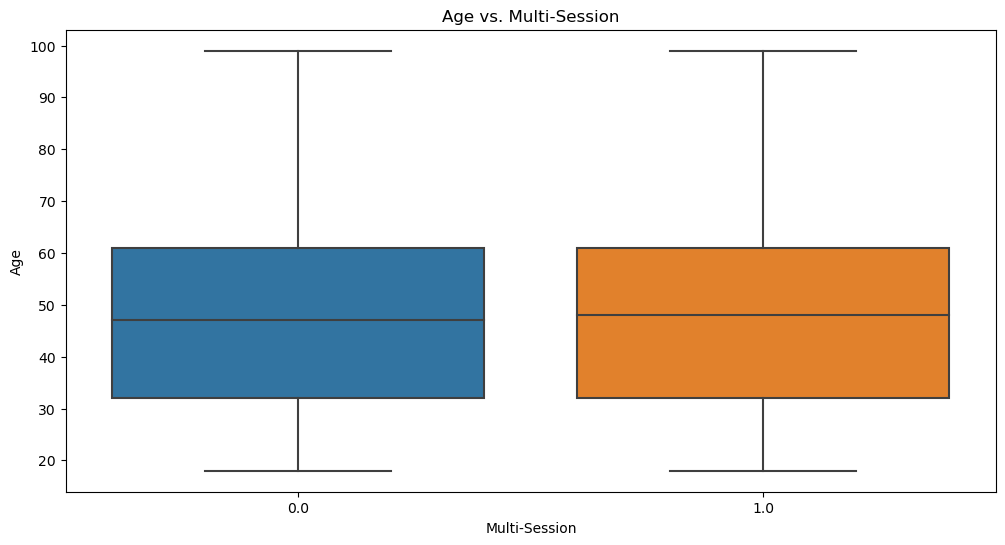

In [21]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='multi_session', y='age', data=df)
plt.title('Age vs. Multi-Session')
plt.xlabel('Multi-Session')
plt.ylabel('Age')
plt.show()

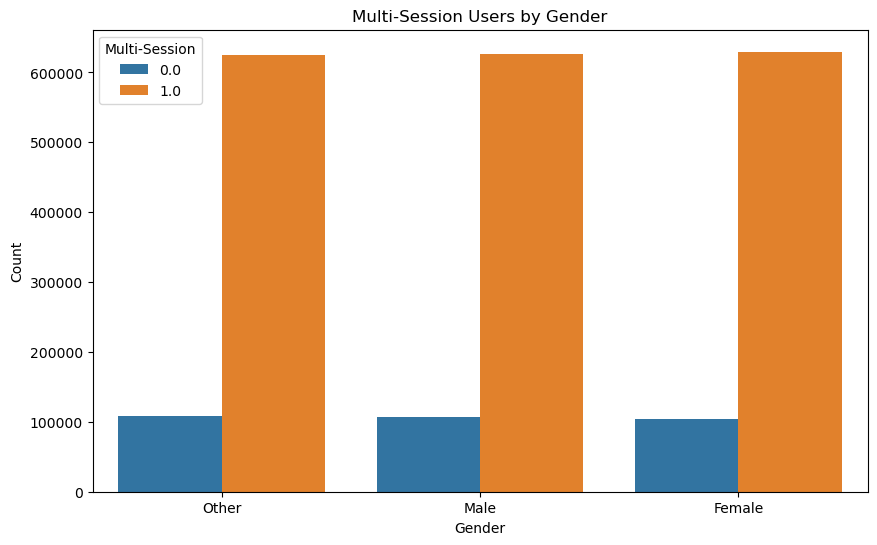

In [22]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='gender', hue='multi_session')
plt.title('Multi-Session Users by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Multi-Session')
plt.show()

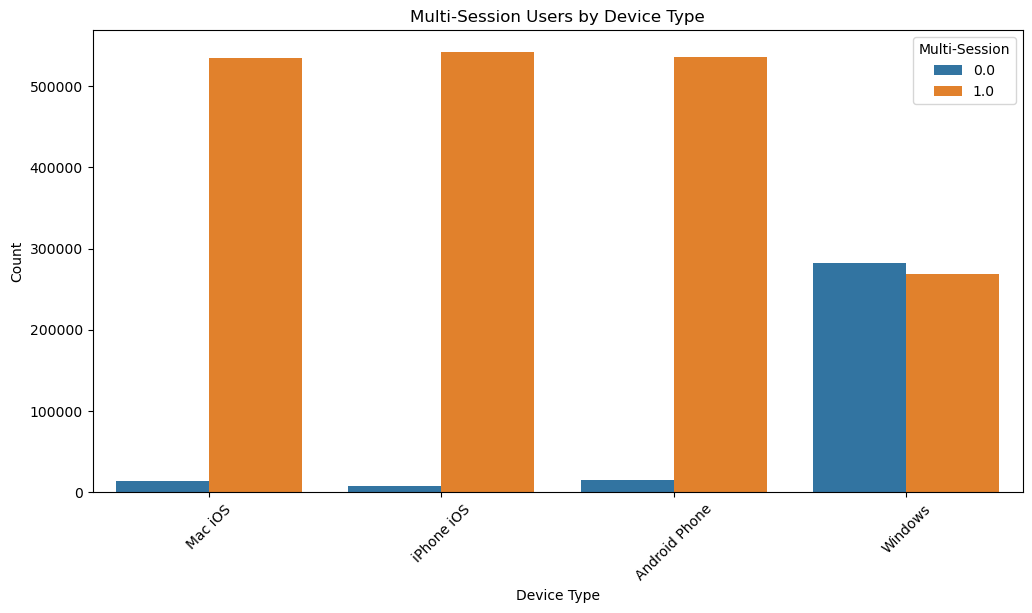

In [23]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='type_of_device', hue='multi_session')
plt.title('Multi-Session Users by Device Type')
plt.xlabel('Device Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Multi-Session')
plt.show()

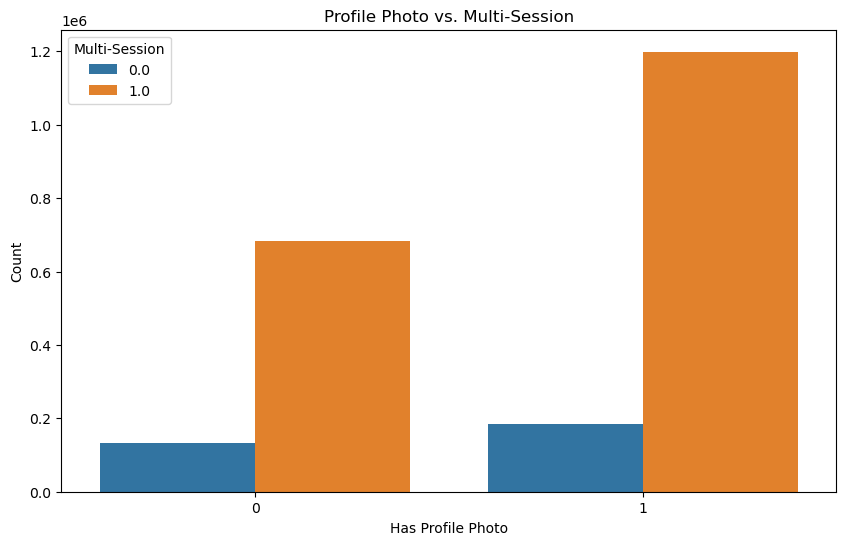

In [24]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='has_profile_photo', hue='multi_session')
plt.title('Profile Photo vs. Multi-Session')
plt.xlabel('Has Profile Photo')
plt.ylabel('Count')
plt.legend(title='Multi-Session')
plt.show()

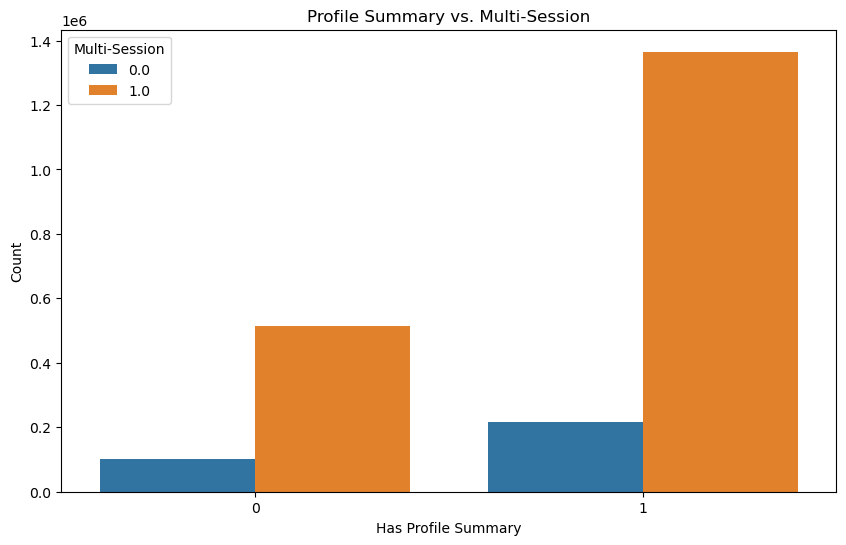

In [25]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='has_profile_summary', hue='multi_session')
plt.title('Profile Summary vs. Multi-Session')
plt.xlabel('Has Profile Summary')
plt.ylabel('Count')
plt.legend(title='Multi-Session')
plt.show()

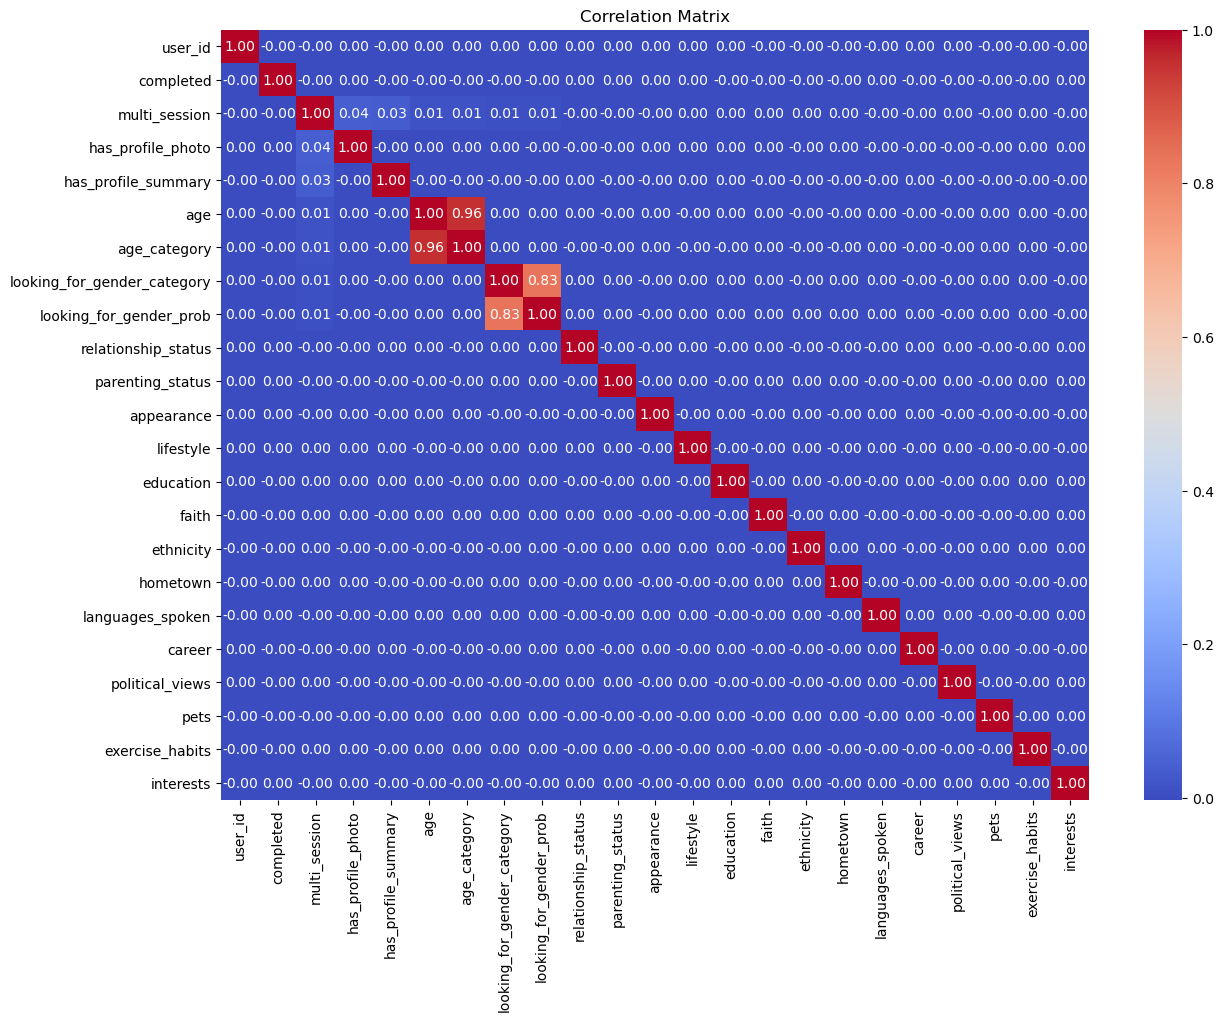

In [26]:
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [27]:
# Feature Engineering and Modeling
df_encoded = df.copy()
categorical_features = ['gender', 'type_of_device', 'website_or_app', 'interest_categories']
for feature in categorical_features:
    df_encoded[feature] = LabelEncoder().fit_transform(df_encoded[feature])

In [28]:
# Define features and target for modeling
X = df_encoded.drop(['multi_session', 'user_id', 'location'], axis=1)
y = df_encoded['multi_session']

In [29]:
# Train Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)


RandomForestClassifier(random_state=42)

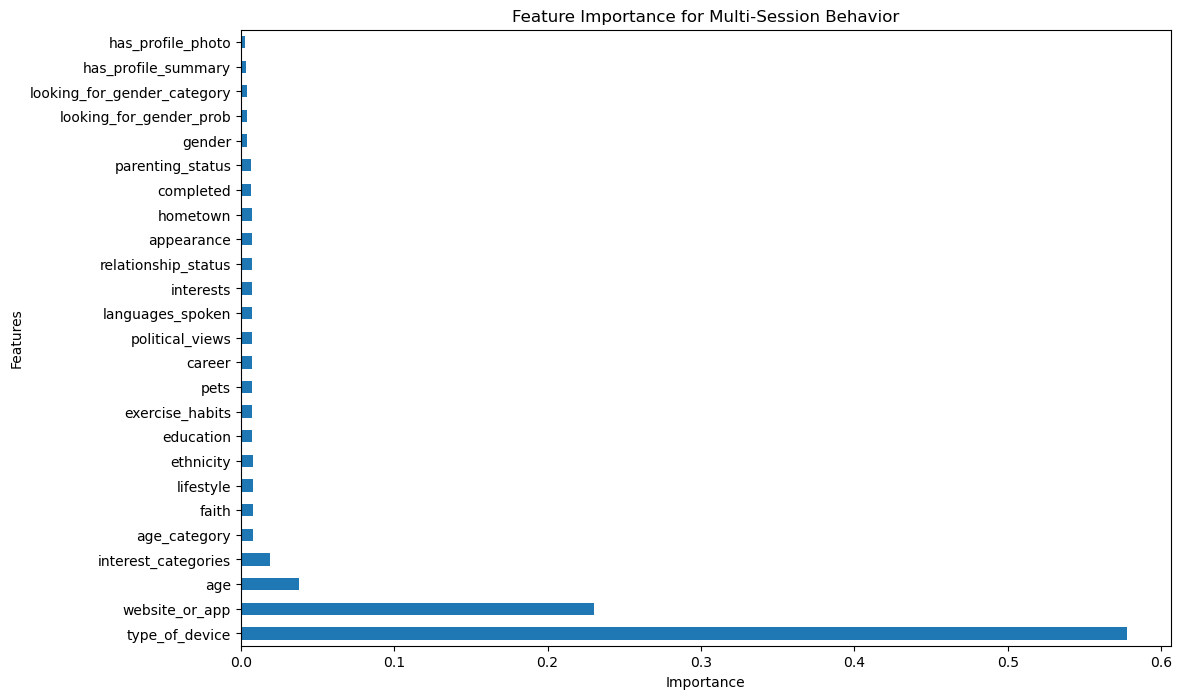

In [30]:
# Plot feature importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(12, 8))
feature_importance.plot(kind='barh')
plt.title('Feature Importance for Multi-Session Behavior')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [35]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
import itertools


In [36]:
# Load the data
df = pd.read_csv('mock_match_group_users_final_adjusted.csv')

In [37]:
# Define the features to analyze for interactions
features = [
    'has_profile_summary', 'has_profile_photo', 'gender', 'age_category',
    'looking_for_gender_category', 'type_of_device', 'website_or_app'
]


In [38]:
# Generate all possible two-way, three-way, etc., interactions
all_interactions = []
for r in range(2, len(features) + 1):
    all_interactions.extend(itertools.combinations(features, r))

In [42]:
# Function to perform statistical tests for each interaction
def test_interactions(df, interactions):
    results = []

    for interaction in interactions:
        feature1, feature2 = interaction[0], interaction[1]

        # Chi-Square test for categorical-categorical interactions
        if df[feature1].dtype == 'object' or df[feature2].dtype == 'object':
            contingency_table = pd.crosstab(df[feature1], df[feature2])
            chi2, p, dof, ex = chi2_contingency(contingency_table)
            test_name = 'Chi-Square'

        # ANOVA for numerical-categorical interactions
        elif df[feature1].dtype != 'object' and df[feature2].dtype == 'object':
            groups = [df[df[feature2] == category][feature1] for category in df[feature2].unique()]
            f_stat, p = f_oneway(*groups)
            test_name = 'ANOVA'

        # T-Test for numerical-numerical interactions
        else:
            t_stat, p = ttest_ind(df[feature1], df[feature2], equal_var=False)
            test_name = 'T-Test'

        # Append results with formatted p-value
        results.append({
            'Interaction': f'{feature1} x {feature2}',
            'Test': test_name,
            'P-Value': f'{p:.3e}' if p < 1e-3 else f'{p:.5f}'  # Format for small p-values
        })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Run statistical tests on the interactions
results_df = test_interactions(df, all_interactions)

In [43]:
# Filter significant results
significant_results = results_df[results_df['P-Value'].astype(float) < 0.05]
print(significant_results)

                                           Interaction    Test    P-Value
0              has_profile_summary x has_profile_photo  T-Test  0.000e+00
2                   has_profile_summary x age_category  T-Test  0.000e+00
3    has_profile_summary x looking_for_gender_category  T-Test  0.000e+00
7                     has_profile_photo x age_category  T-Test  0.000e+00
8      has_profile_photo x looking_for_gender_category  T-Test  0.000e+00
..                                                 ...     ...        ...
113            has_profile_summary x has_profile_photo  T-Test  0.000e+00
114            has_profile_summary x has_profile_photo  T-Test  0.000e+00
115            has_profile_summary x has_profile_photo  T-Test  0.000e+00
116            has_profile_summary x has_profile_photo  T-Test  0.000e+00
119            has_profile_summary x has_profile_photo  T-Test  0.000e+00

[64 rows x 3 columns]


In [44]:
# Encode categorical features if needed
for feature in ['gender', 'type_of_device', 'website_or_app']:
    df[feature] = pd.Categorical(df[feature]).codes

In [45]:
# Generate all possible two-way interactions
interactions = list(itertools.combinations(features, 2))

In [46]:
# Create interaction terms in the dataset
for feature1, feature2 in interactions:
    interaction_term = f'{feature1}_x_{feature2}'
    df[interaction_term] = df[feature1] * df[feature2]


In [47]:
# Define the independent variables (including interaction terms)
X = df[features + [f'{f1}_x_{f2}' for f1, f2 in interactions]]

In [49]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
# Add a constant to the independent variables
X = sm.add_constant(X)


In [51]:
# Define the dependent variable
y = df['multi_session']  # Adjust this variable to your dependent variable name


In [52]:
# Fit a Multinomial Logistic Regression model
model = sm.MNLogit(y, X)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.318536
         Iterations 9


In [53]:
# Display the summary of the model
print(result.summary())

                          MNLogit Regression Results                          
Dep. Variable:          multi_session   No. Observations:              2200000
Model:                        MNLogit   Df Residuals:                  2199971
Method:                           MLE   Df Model:                           28
Date:                Mon, 23 Sep 2024   Pseudo R-squ.:                  0.2301
Time:                        23:32:35   Log-Likelihood:            -7.0078e+05
converged:                       True   LL-Null:                   -9.1018e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                  multi_session=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
const                                                 1.3958      0.034     41.357      0.000       1.330       1.462
has_profile_su

In [55]:
# Check the names of all coefficients in the model
print("Model Coefficients:")
print(result.params.index)

Model Coefficients:
Index(['const', 'has_profile_summary', 'has_profile_photo', 'gender',
       'age_category', 'looking_for_gender_category', 'type_of_device',
       'website_or_app', 'has_profile_summary_x_has_profile_photo',
       'has_profile_summary_x_gender', 'has_profile_summary_x_age_category',
       'has_profile_summary_x_looking_for_gender_category',
       'has_profile_summary_x_type_of_device',
       'has_profile_summary_x_website_or_app', 'has_profile_photo_x_gender',
       'has_profile_photo_x_age_category',
       'has_profile_photo_x_looking_for_gender_category',
       'has_profile_photo_x_type_of_device',
       'has_profile_photo_x_website_or_app', 'gender_x_age_category',
       'gender_x_looking_for_gender_category', 'gender_x_type_of_device',
       'gender_x_website_or_app', 'age_category_x_looking_for_gender_category',
       'age_category_x_type_of_device', 'age_category_x_website_or_app',
       'looking_for_gender_category_x_type_of_device',
       'loo

In [57]:
interaction_columns = []
for feature1, feature2 in interactions:
    interaction_term = f'{feature1}_x_{feature2}'
    df[interaction_term] = df[feature1] * df[feature2]
    interaction_columns.append(interaction_term)

In [58]:
# Define the independent variables (including interaction terms)
X = df[features + interaction_columns]

# Add a constant to the independent variables
X = sm.add_constant(X)

# Define the dependent variable
y = df['multi_session']  # Adjust this variable to your dependent variable name

# Fit a Multinomial Logistic Regression model
model = sm.MNLogit(y, X)
result = model.fit()


Optimization terminated successfully.
         Current function value: 0.318536
         Iterations 9


In [59]:
# Display the summary of the model
print(result.summary())


                          MNLogit Regression Results                          
Dep. Variable:          multi_session   No. Observations:              2200000
Model:                        MNLogit   Df Residuals:                  2199971
Method:                           MLE   Df Model:                           28
Date:                Mon, 23 Sep 2024   Pseudo R-squ.:                  0.2301
Time:                        23:38:45   Log-Likelihood:            -7.0078e+05
converged:                       True   LL-Null:                   -9.1018e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                  multi_session=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
const                                                 1.3958      0.034     41.357      0.000       1.330       1.462
has_profile_su

In [60]:
# Check the names of all coefficients in the model
print("Model Coefficients:")
print(result.params.index)

Model Coefficients:
Index(['const', 'has_profile_summary', 'has_profile_photo', 'gender',
       'age_category', 'looking_for_gender_category', 'type_of_device',
       'website_or_app', 'has_profile_summary_x_has_profile_photo',
       'has_profile_summary_x_gender', 'has_profile_summary_x_age_category',
       'has_profile_summary_x_looking_for_gender_category',
       'has_profile_summary_x_type_of_device',
       'has_profile_summary_x_website_or_app', 'has_profile_photo_x_gender',
       'has_profile_photo_x_age_category',
       'has_profile_photo_x_looking_for_gender_category',
       'has_profile_photo_x_type_of_device',
       'has_profile_photo_x_website_or_app', 'gender_x_age_category',
       'gender_x_looking_for_gender_category', 'gender_x_type_of_device',
       'gender_x_website_or_app', 'age_category_x_looking_for_gender_category',
       'age_category_x_type_of_device', 'age_category_x_website_or_app',
       'looking_for_gender_category_x_type_of_device',
       'loo

In [75]:
# Inspect all coefficient names to understand their labeling in the model
all_coeff_names = result.params.index.tolist()
print("All Coefficient Names in Model:")
print(all_coeff_names)


All Coefficient Names in Model:
['const', 'has_profile_summary', 'has_profile_photo', 'gender', 'age_category', 'looking_for_gender_category', 'type_of_device', 'website_or_app', 'has_profile_summary_x_has_profile_photo', 'has_profile_summary_x_gender', 'has_profile_summary_x_age_category', 'has_profile_summary_x_looking_for_gender_category', 'has_profile_summary_x_type_of_device', 'has_profile_summary_x_website_or_app', 'has_profile_photo_x_gender', 'has_profile_photo_x_age_category', 'has_profile_photo_x_looking_for_gender_category', 'has_profile_photo_x_type_of_device', 'has_profile_photo_x_website_or_app', 'gender_x_age_category', 'gender_x_looking_for_gender_category', 'gender_x_type_of_device', 'gender_x_website_or_app', 'age_category_x_looking_for_gender_category', 'age_category_x_type_of_device', 'age_category_x_website_or_app', 'looking_for_gender_category_x_type_of_device', 'looking_for_gender_category_x_website_or_app', 'type_of_device_x_website_or_app']


In [76]:
# Define expected interaction terms manually if they match exactly
interaction_terms = [
    'has_profile_summary_x_has_profile_photo', 'has_profile_summary_x_gender', 
    'has_profile_summary_x_age_category', 'has_profile_summary_x_looking_for_gender_category', 
    'has_profile_summary_x_type_of_device', 'has_profile_summary_x_website_or_app', 
    'has_profile_photo_x_gender', 'has_profile_photo_x_age_category', 
    'has_profile_photo_x_looking_for_gender_category', 'has_profile_photo_x_type_of_device', 
    'has_profile_photo_x_website_or_app', 'gender_x_age_category', 
    'gender_x_looking_for_gender_category', 'gender_x_type_of_device', 
    'gender_x_website_or_app', 'age_category_x_looking_for_gender_category', 
    'age_category_x_type_of_device', 'age_category_x_website_or_app', 
    'looking_for_gender_category_x_type_of_device', 'looking_for_gender_category_x_website_or_app', 
    'type_of_device_x_website_or_app'
]

In [77]:
# Match and extract only the coefficients for the defined interaction terms
interaction_coeffs = result.params.loc[result.params.index.intersection(interaction_terms)]


In [78]:
# Check the extracted interaction coefficients
print("Extracted Interaction Coefficients:")
print(interaction_coeffs)

Extracted Interaction Coefficients:
                                                          0
has_profile_summary_x_has_profile_photo           -0.180994
has_profile_summary_x_gender                       0.010954
has_profile_summary_x_age_category                -0.012384
has_profile_summary_x_looking_for_gender_category -0.005670
has_profile_summary_x_type_of_device              -0.052182
has_profile_summary_x_website_or_app              -1.018964
has_profile_photo_x_gender                        -0.002871
has_profile_photo_x_age_category                  -0.011261
has_profile_photo_x_looking_for_gender_category   -0.008030
has_profile_photo_x_type_of_device                -0.052004
has_profile_photo_x_website_or_app                -1.229312
gender_x_age_category                             -0.001609
gender_x_looking_for_gender_category               0.006428
gender_x_type_of_device                           -0.002842
gender_x_website_or_app                           -0.010322
age_

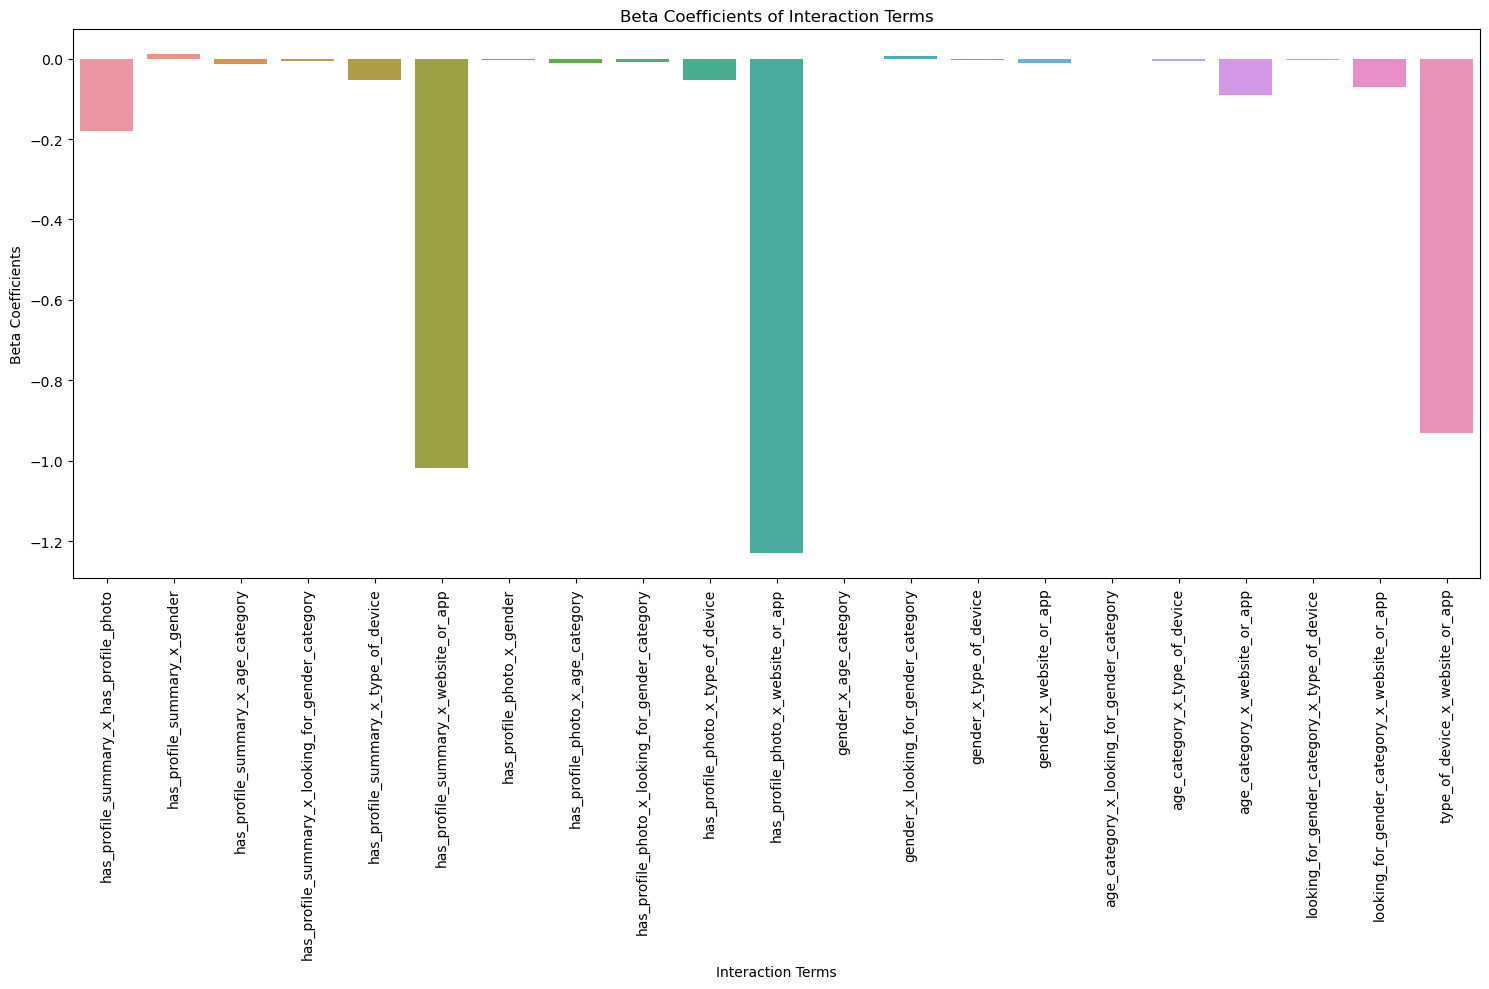

In [79]:
# Ensure interaction_coeffs has valid data before plotting
if interaction_coeffs.empty or len(interaction_coeffs.values.flatten()) == 0:
    print("Error: No valid interaction coefficients found.")
else:
    # Create a DataFrame for plotting to ensure correct indexing and length
    coeffs_df = pd.DataFrame({
        'Interaction': interaction_coeffs.index,
        'Coefficient': interaction_coeffs.values.flatten()
    })

    # Plot the interaction coefficients using seaborn
    plt.figure(figsize=(15, 10))
    sns.barplot(x='Interaction', y='Coefficient', data=coeffs_df, ci=None)
    plt.xticks(rotation=90)
    plt.title('Beta Coefficients of Interaction Terms')
    plt.xlabel('Interaction Terms')
    plt.ylabel('Beta Coefficients')
    plt.tight_layout()
    plt.show()